In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from scipy.stats import pearsonr, norm

In [2]:
#move to data folder
os.chdir('/project/4180000.23/fMRI_Wessel/Beh-fMRI_Corr/')

In [3]:
df = pd.read_excel('Behavior_fMRI_combined.xlsx')
df.head()

,Mouse ID,Group,ICA_5,ICA_6,total_distance
0,455715,Control,2.902049,4.510722,22699.649643
1,455716,Control,6.468038,10.635339,22141.274451
2,455717,Control,4.015607,7.618884,19361.877181
3,455718,Control,1.766053,3.140874,22988.146639
4,455721,Fluoxetine,4.575714,7.654406,19634.123666


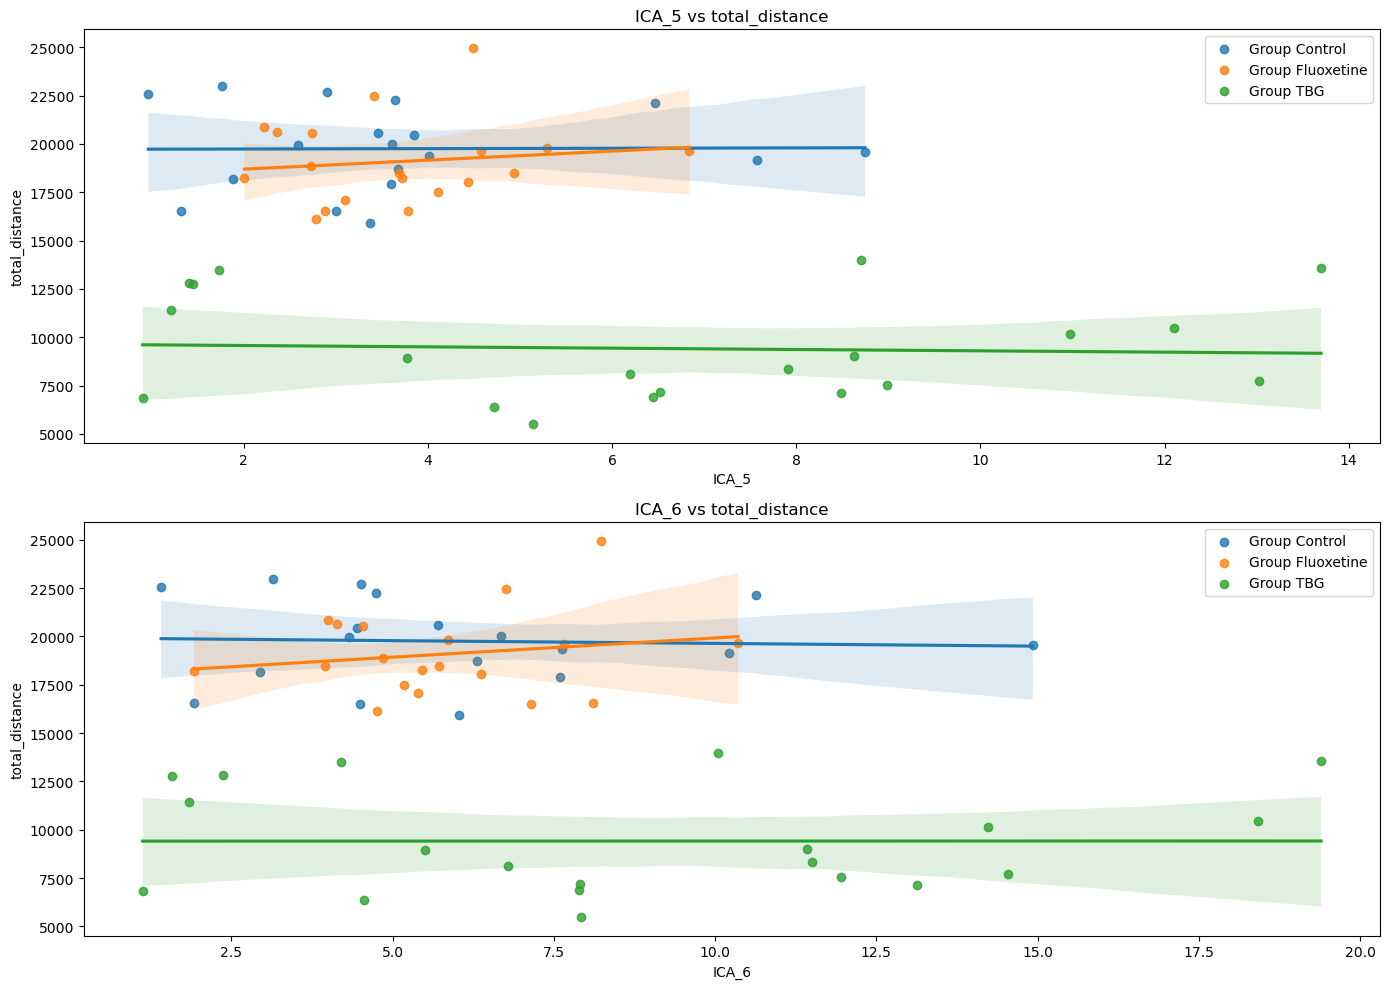

In [4]:
# Function to calculate 95% confidence interval for Pearson's r
def pearson_confidence_interval(r, n, confidence=0.95):
    if n < 4:  # Avoid errors with small samples
        return np.nan, np.nan
    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_crit = norm.ppf(1 - (1 - confidence) / 2)  # Critical z-score (1.96 for 95% CI)
    z_lower, z_upper = z - z_crit * se, z + z_crit * se  # CI bounds in z-space
    r_lower, r_upper = np.tanh(z_lower), np.tanh(z_upper)  # Convert back to r
    return r_lower, r_upper

# Calculate Pearson correlation and 95% CI for each group
groups = df['Group'].unique()
results = []

for group in groups:
    group_df = df[df['Group'] == group]
    n = len(group_df)
    
    corr_1, p_1 = pearsonr(group_df['ICA_5'], group_df['total_distance'])
    corr_2, p_2 = pearsonr(group_df['ICA_6'], group_df['total_distance'])

    ci_1_lower, ci_1_upper = pearson_confidence_interval(corr_1, n)
    ci_2_lower, ci_2_upper = pearson_confidence_interval(corr_2, n)

    results.append({
        'Group': group,
        'Correlation_ICA_5_Distance': corr_1,
        'CI_Lower_ICA_5': ci_1_lower,
        'CI_Upper_ICA_5': ci_1_upper,
        'p_value_ICA_5_Distance': p_1,
        'Correlation_ICA_6_Distance': corr_2,
        'CI_Lower_ICA_6': ci_2_lower,
        'CI_Upper_ICA_6': ci_2_upper,
        'p_value_ICA_6_Distance': p_2
    })

results_df = pd.DataFrame(results)
results_df.to_csv('correlation_results_with_CI.csv', index=False)

# Scatterplots with linear best fit lines
plt.figure(figsize=(14, 10))

for i, (intensity, title) in enumerate(zip(['ICA_5', 'ICA_6'], 
                                           ['ICA_5 vs total_distance', 'ICA_6 vs total_distance']), start=1):
    plt.subplot(2, 1, i)
    for group in groups:
        group_df = df[df['Group'] == group]
        sns.regplot(x=group_df[intensity], y=group_df['total_distance'], label=f'Group {group}', ci=95)
    plt.title(title)
    plt.xlabel(intensity)
    plt.ylabel('total_distance')
    plt.legend()

plt.tight_layout()
plt.savefig('scatterplots_with_fit_lines.png')
plt.savefig('scatterplots_with_fit_lines.svg')
plt.show()

# Statistical test for differences in correlation strength between groups
def fisher_z(r):
    return np.arctanh(r)

def compare_correlations(r1, r2, n1, n2):
    z1 = fisher_z(r1)
    z2 = fisher_z(r2)
    se_diff = np.sqrt(1/(n1-3) + 1/(n2-3))
    z = (z1 - z2) / se_diff
    p_value = 2 * (1 - norm.cdf(np.abs(z)))
    return z, p_value

group_pairs = [(g1, g2) for i, g1 in enumerate(groups) for g2 in groups[i+1:]]
comparison_results = []

for intensity in ['ICA_5', 'ICA_6']:
    for g1, g2 in group_pairs:
        n1 = len(df[df['Group'] == g1])
        n2 = len(df[df['Group'] == g2])
        r1 = results_df[results_df['Group'] == g1][f'Correlation_{intensity}_Distance'].values[0]
        r2 = results_df[results_df['Group'] == g2][f'Correlation_{intensity}_Distance'].values[0]
        z, p_value = compare_correlations(r1, r2, n1, n2)
        comparison_results.append({
            'Intensity': intensity,
            'Group1': g1,
            'Group2': g2,
            'Z_value': z,
            'p_value': p_value
        })

comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('correlation_comparison_results.csv', index=False)